In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

In [32]:
# --------------------------------------------------------------------------------
# Part 1: Data Loading - fetching ASX200 data from Yahoo Finance
# --------------------------------------------------------------------------------
print("Fetching ASX200 data from Yahoo Finance...")
data = yf.download('^AXJO', start='2020-01-01', end='2025-01-01')
print(f"Data fetched successfully. Shape: {data.shape}")

# Display the first few rows
print("\nFirst 5 rows of ASX200 data:")
print(data.head())

# Check for missing values
print(f"\nMissing values:\n{data.isnull().sum()}")

# If any missing values, forward fill
if data.isnull().sum().sum() > 0:
    data = data.fillna(method='ffill')

# Prepare the data for our analysis
stocks_df = data.reset_index().rename(columns={'Date': 'date'})
stocks_df['date'] = pd.to_datetime(stocks_df['date'])

# Calculate returns
stocks_df['returns'] = stocks_df['Close'].pct_change() * 100
stocks_df = stocks_df.dropna()

# Create a copy with just the Close price for ARIMA modeling
close_series = data['Close'].copy()

# Display basic statistics
print("\nBasic statistics of ASX200 data:")
print(stocks_df.describe())

[*********************100%***********************]  1 of 1 completed

Fetching ASX200 data from Yahoo Finance...
Data fetched successfully. Shape: (1266, 5)

First 5 rows of ASX200 data:
Price             Close         High          Low         Open  Volume
Ticker            ^AXJO        ^AXJO        ^AXJO        ^AXJO   ^AXJO
Date                                                                  
2020-01-02  6690.600098  6709.200195  6669.200195  6684.100098  304900
2020-01-03  6733.500000  6788.200195  6690.600098  6690.600098  365200
2020-01-06  6735.700195  6738.600098  6671.700195  6733.100098  469800
2020-01-07  6826.399902  6834.299805  6735.700195  6735.700195  447400
2020-01-08  6817.600098  6831.700195  6749.600098  6826.399902  570700

Missing values:
Price   Ticker
Close   ^AXJO     0
High    ^AXJO     0
Low     ^AXJO     0
Open    ^AXJO     0
Volume  ^AXJO     0
dtype: int64

Basic statistics of ASX200 data:
Price                            date        Close         High          Low  \
Ticker                                       ^AXJO      


Saved ASX200 closing prices visualization to 'asx200_closing_prices.png'
Saved ASX200 daily returns visualization to 'asx200_daily_returns.png'
Saved ASX200 rolling statistics visualization to 'asx200_rolling_statistics.png'


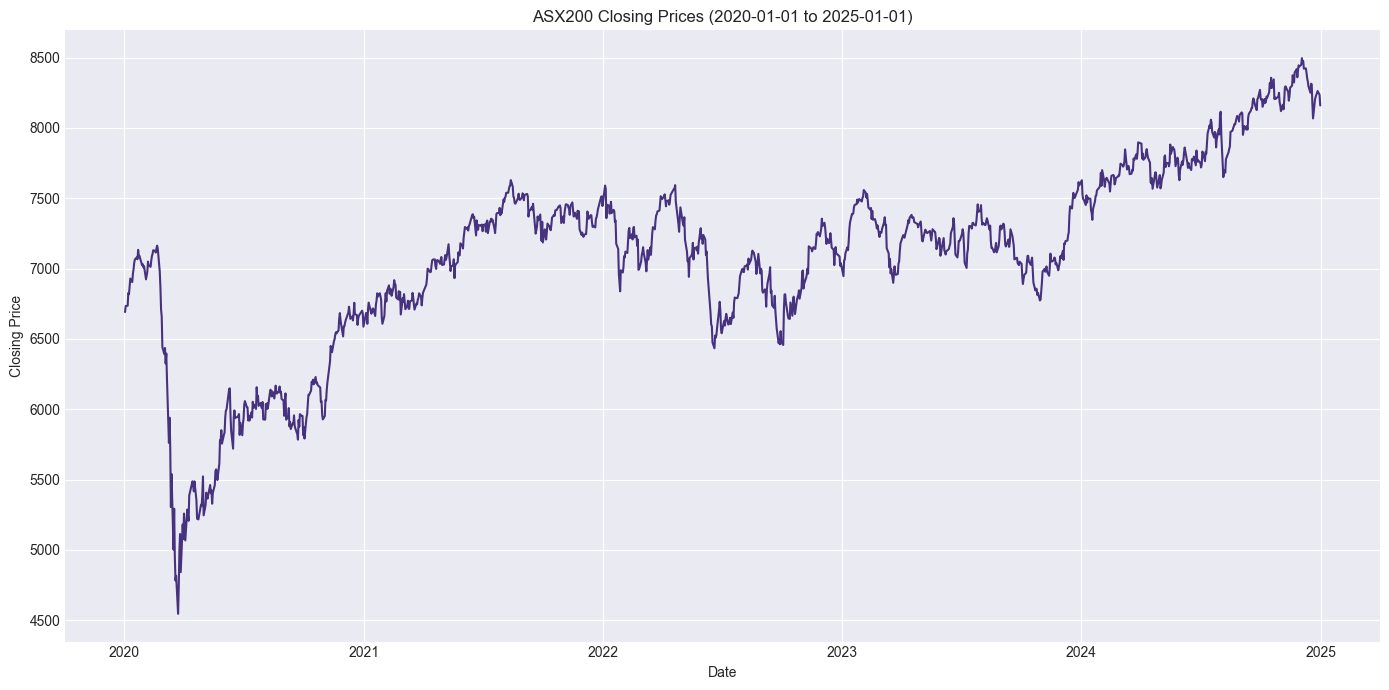

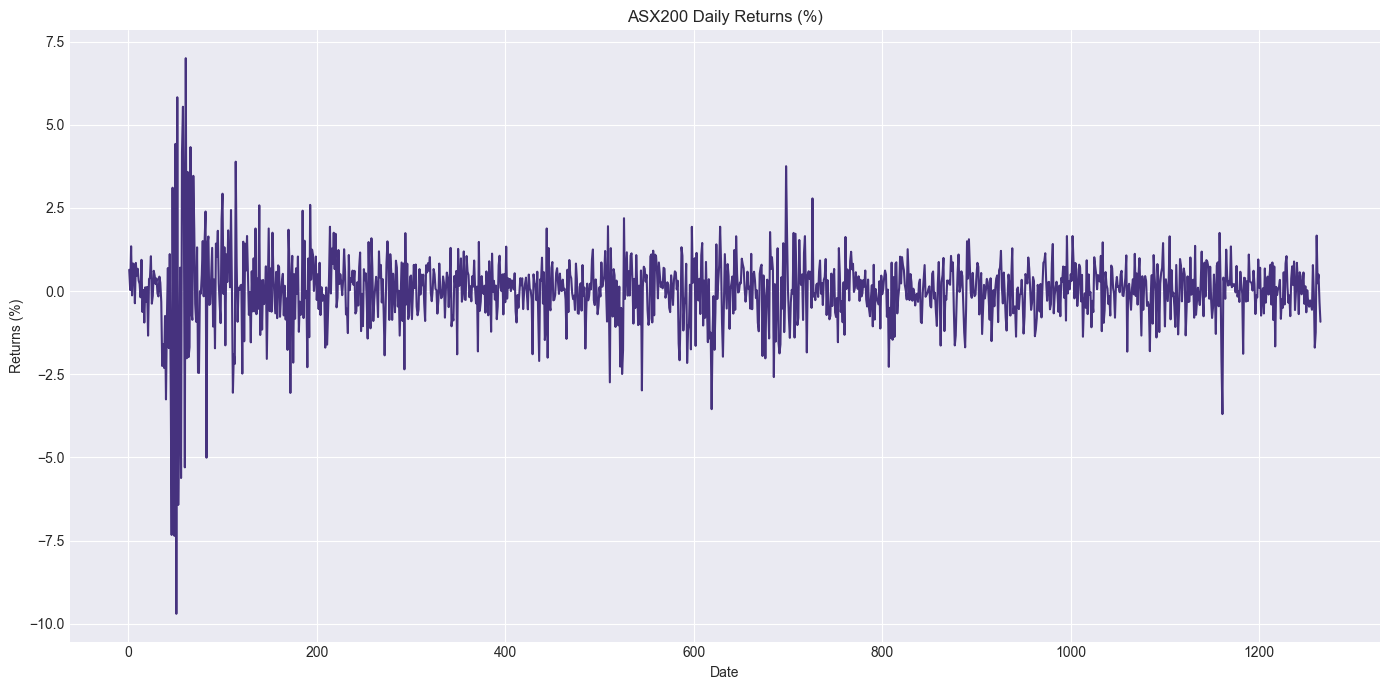

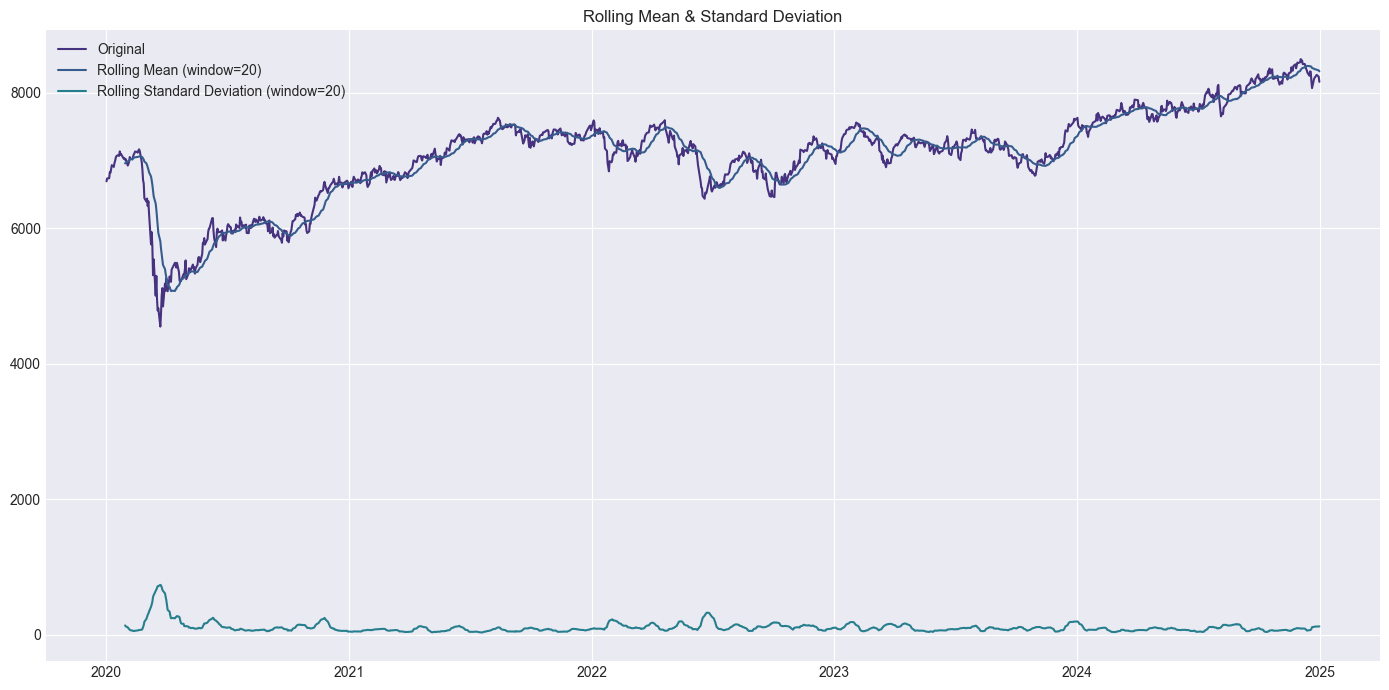

In [33]:
# --------------------------------------------------------------------------------
# Part 2: Visualize the time series
# --------------------------------------------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(close_series)
plt.title('ASX200 Closing Prices (2020-01-01 to 2025-01-01)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.savefig('asx200_closing_prices.png')
print("\nSaved ASX200 closing prices visualization to 'asx200_closing_prices.png'")

# Visualize returns
plt.figure(figsize=(14, 7))
plt.plot(stocks_df['returns'])
plt.title('ASX200 Daily Returns (%)')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.grid(True)
plt.tight_layout()
plt.savefig('asx200_daily_returns.png')
print("Saved ASX200 daily returns visualization to 'asx200_daily_returns.png'")

# Rolling statistics (window of 20 days)
window = 20
rolling_mean = close_series.rolling(window=window).mean()
rolling_std = close_series.rolling(window=window).std()

# Plot rolling statistics
plt.figure(figsize=(14, 7))
plt.title('Rolling Mean & Standard Deviation')
plt.plot(close_series, label='Original')
plt.plot(rolling_mean, label=f'Rolling Mean (window={window})')
plt.plot(rolling_std, label=f'Rolling Standard Deviation (window={window})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('asx200_rolling_statistics.png')
print("Saved ASX200 rolling statistics visualization to 'asx200_rolling_statistics.png'")

In [34]:
# --------------------------------------------------------------------------------
# Part 3: Technical Indicators
# --------------------------------------------------------------------------------
print("\n===== Calculating Technical Indicators =====")

def calculate_technical_indicators(df, close_col='Close', window=14):
    """Calculate RSI and MACD for a given dataframe."""
    # Copy dataframe to avoid modifying original
    df = df.copy().sort_values('date')
    
    # Calculate daily returns
    df['returns'] = df[close_col].pct_change()
    
    # Calculate RSI
    df['gain'] = np.where(df['returns'] > 0, df['returns'], 0)
    df['loss'] = np.where(df['returns'] < 0, -df['returns'], 0)
    
    # Calculate average gain and average loss
    avg_gain = df['gain'].rolling(window=window).mean()
    avg_loss = df['loss'].rolling(window=window).mean()
    
    # Calculate RS and RSI
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Calculate MACD
    df['EMA12'] = df[close_col].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df[close_col].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    
    return df

# Apply technical indicators to ASX200 data
stocks_df = calculate_technical_indicators(stocks_df)
print("Technical indicators calculated successfully")
print("\nSample data with technical indicators:")
print(stocks_df[['date', 'Close', 'RSI', 'MACD', 'Signal_Line']].head(10))


===== Calculating Technical Indicators =====
Technical indicators calculated successfully

Sample data with technical indicators:
Price        date        Close RSI       MACD Signal_Line
Ticker                   ^AXJO                           
1      2020-01-03  6733.500000 NaN   0.000000    0.000000
2      2020-01-06  6735.700195 NaN   0.175514    0.035103
3      2020-01-07  6826.399902 NaN   7.546329    1.537348
4      2020-01-08  6817.600098 NaN  12.533208    3.736520
5      2020-01-09  6874.200195 NaN  20.812585    7.151733
6      2020-01-10  6929.000000 NaN  31.433591   12.008105
7      2020-01-13  6903.700195 NaN  37.378456   17.082175
8      2020-01-14  6962.200195 NaN  46.276815   22.921103
9      2020-01-15  6994.799805 NaN  55.321632   29.401209
10     2020-01-16  7041.799805 NaN  65.526868   36.626341


In [35]:
# --------------------------------------------------------------------------------
# Part 4: Sentiment Analysis with News Data
# --------------------------------------------------------------------------------
print("\n===== Attempting to Fetch News Data for Sentiment Analysis =====")

try:
    # Try to load news data (optional - use placeholder if no news data available)
    # This would be more effective with a real news dataset for ASX
    news_available = False
    
    # Create placeholder sentiment data (since we don't have actual news data for ASX200)
    print("Creating placeholder sentiment data (could be replaced with actual news sentiment)...")
    
    # Download VADER lexicon if needed
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')
    
    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Create a dataframe with dates matching our stock data
    daily_sentiment = pd.DataFrame()
    daily_sentiment['date'] = stocks_df['date'].unique()
    
    # Add placeholder neutral sentiment values
    # In a real implementation, you would analyze actual news headlines
    daily_sentiment['compound'] = 0
    daily_sentiment['negative'] = 0
    daily_sentiment['neutral'] = 1
    daily_sentiment['positive'] = 0
    
    print("Placeholder sentiment data created")
    print(daily_sentiment.head())
    
except Exception as e:
    print(f"Error during sentiment data preparation: {e}")
    print("Continuing with stock data only")
    daily_sentiment = pd.DataFrame()
    daily_sentiment['date'] = stocks_df['date'].unique()
    daily_sentiment['compound'] = 0
    daily_sentiment['negative'] = 0
    daily_sentiment['neutral'] = 1
    daily_sentiment['positive'] = 0


===== Attempting to Fetch News Data for Sentiment Analysis =====
Creating placeholder sentiment data (could be replaced with actual news sentiment)...
Placeholder sentiment data created
        date  compound  negative  neutral  positive
0 2020-01-03         0         0        1         0
1 2020-01-06         0         0        1         0
2 2020-01-07         0         0        1         0
3 2020-01-08         0         0        1         0
4 2020-01-09         0         0        1         0


In [36]:
# --------------------------------------------------------------------------------
# Part 5: Data Integration - Merge Technical Indicators with Sentiment
# --------------------------------------------------------------------------------
print("\n===== Merging Stock Data with Sentiment Scores =====")

# Print detailed information about the dataframes
print("\nStock dataframe columns (before fixing):")
print(stocks_df.columns)

# The stocks dataframe appears to have empty column names or multi-index issues
# Let's create proper column names based on the original data structure
if isinstance(stocks_df.columns, pd.MultiIndex):
    # Get column names and levels
    print("Detected MultiIndex columns in stocks_df. Restructuring...")
    # Extract proper column names
    new_cols = []
    for col in stocks_df.columns:
        if isinstance(col, tuple):
            # Join non-empty parts of column tuple
            parts = [str(part) for part in col if part]
            new_cols.append('_'.join(parts))
        else:
            new_cols.append(str(col))
    
    stocks_df.columns = new_cols
else:
    # If not MultiIndex but still problematic, recreate proper columns
    print("Fixing problematic column names...")
    # Assume standard structure for stock data
    potential_cols = ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'returns']
    if len(stocks_df.columns) >= len(potential_cols):
        stocks_df.columns = potential_cols + [f'col_{i}' for i in range(len(stocks_df.columns) - len(potential_cols))]

# Ensure we have a proper date column
if 'date' not in stocks_df.columns and isinstance(stocks_df.index, pd.DatetimeIndex):
    print("Creating date column from DatetimeIndex")
    stocks_df = stocks_df.reset_index()
    stocks_df = stocks_df.rename(columns={'index': 'date'})
elif 'date' not in stocks_df.columns:
    # Check if there's a column that looks like a date
    for i, col in enumerate(stocks_df.columns):
        # Check first 5 rows to see if values look like dates
        first_values = stocks_df.iloc[:5, i].astype(str)
        date_like = all(['20' in str(val) for val in first_values])  # Crude check for year
        
        if date_like:
            print(f"Column {col} appears to contain dates. Converting to 'date' column.")
            stocks_df = stocks_df.rename(columns={col: 'date'})
            break
    
    # If still no date column, we need to create one from the row numbers
    if 'date' not in stocks_df.columns:
        print("No date column found. Creating one from scratch using original data index...")
        # Use the original data index which should be dates
        if isinstance(data.index, pd.DatetimeIndex):
            stocks_df['date'] = data.index
        else:
            print("WARNING: Unable to create proper date column. Using row numbers as a fallback.")
            stocks_df['date'] = pd.date_range(start='2020-01-01', periods=len(stocks_df))

# Ensure date column is datetime type
stocks_df['date'] = pd.to_datetime(stocks_df['date'])
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

print("\nFixed stocks_df columns:")
print(stocks_df.columns)
print("\nFirst 5 rows of stocks_df:")
print(stocks_df.head())

# Now try the merge
print("\n===== Attempting Merge Operation =====")
try:
    merged_df = pd.merge(stocks_df, daily_sentiment, on='date', how='left')
    print("Merge successful!")
    print(f"Merged dataframe shape: {merged_df.shape}")
except Exception as e:
    print(f"Merge failed with error: {e}")
    
    # As a last resort, create a minimal merged dataframe manually
    print("\nCreating a merged dataframe with placeholder sentiment values...")
    merged_df = stocks_df.copy()
    for col in ['compound', 'negative', 'neutral', 'positive']:
        if col not in merged_df.columns:
            merged_df[col] = 0
    print("Created merged dataframe with placeholder sentiment values")

# Fill missing sentiment values
sentiment_cols = ['compound', 'negative', 'neutral', 'positive']
merged_df[sentiment_cols] = merged_df[sentiment_cols].fillna(0)

print("Merged data sample:")
print(merged_df.head())

# Save the processed data
merged_df.to_csv('processed_asx200_with_indicators.csv', index=False)
print("Processed data saved to 'processed_asx200_with_indicators.csv'")


===== Merging Stock Data with Sentiment Scores =====

Stock dataframe columns (before fixing):
MultiIndex([(          'date',      ''),
            (         'Close', '^AXJO'),
            (          'High', '^AXJO'),
            (           'Low', '^AXJO'),
            (          'Open', '^AXJO'),
            (        'Volume', '^AXJO'),
            (       'returns',      ''),
            (          'gain',      ''),
            (          'loss',      ''),
            (           'RSI',      ''),
            (         'EMA12',      ''),
            (         'EMA26',      ''),
            (          'MACD',      ''),
            (   'Signal_Line',      ''),
            ('MACD_Histogram',      '')],
           names=['Price', 'Ticker'])
Detected MultiIndex columns in stocks_df. Restructuring...

Fixed stocks_df columns:
Index(['date', 'Close_^AXJO', 'High_^AXJO', 'Low_^AXJO', 'Open_^AXJO',
       'Volume_^AXJO', 'returns', 'gain', 'loss', 'RSI', 'EMA12', 'EMA26',
       'MACD', 'Sig

PermissionError: [Errno 13] Permission denied: 'processed_asx200_with_indicators.csv'


===== Checking Stationarity =====
Augmented Dickey-Fuller Test Results:
ADF Statistic             -1.678766
p-value                    0.442085
# Lags Used               13.000000
# Observations Used     1252.000000
Critical Value (1%)       -3.435584
Critical Value (5%)       -2.863851
Critical Value (10%)      -2.568001
dtype: float64
The series is non-stationary (Fail to reject H0)

Applying first differencing to make series stationary...
Saved differenced series visualization to 'differenced_series.png'

Augmented Dickey-Fuller Test Results (After First Differencing):
ADF Statistic          -9.373648e+00
p-value                 7.264375e-16
# Lags Used             1.200000e+01
# Observations Used     1.252000e+03
Critical Value (1%)    -3.435584e+00
Critical Value (5%)    -2.863851e+00
Critical Value (10%)   -2.568001e+00
dtype: float64
The differenced series is stationary (Reject H0)

ACF/PACF plots saved to 'acf_pacf_plots.png'

Based on ACF/PACF plots:
Confirmed d value: 1
Exam

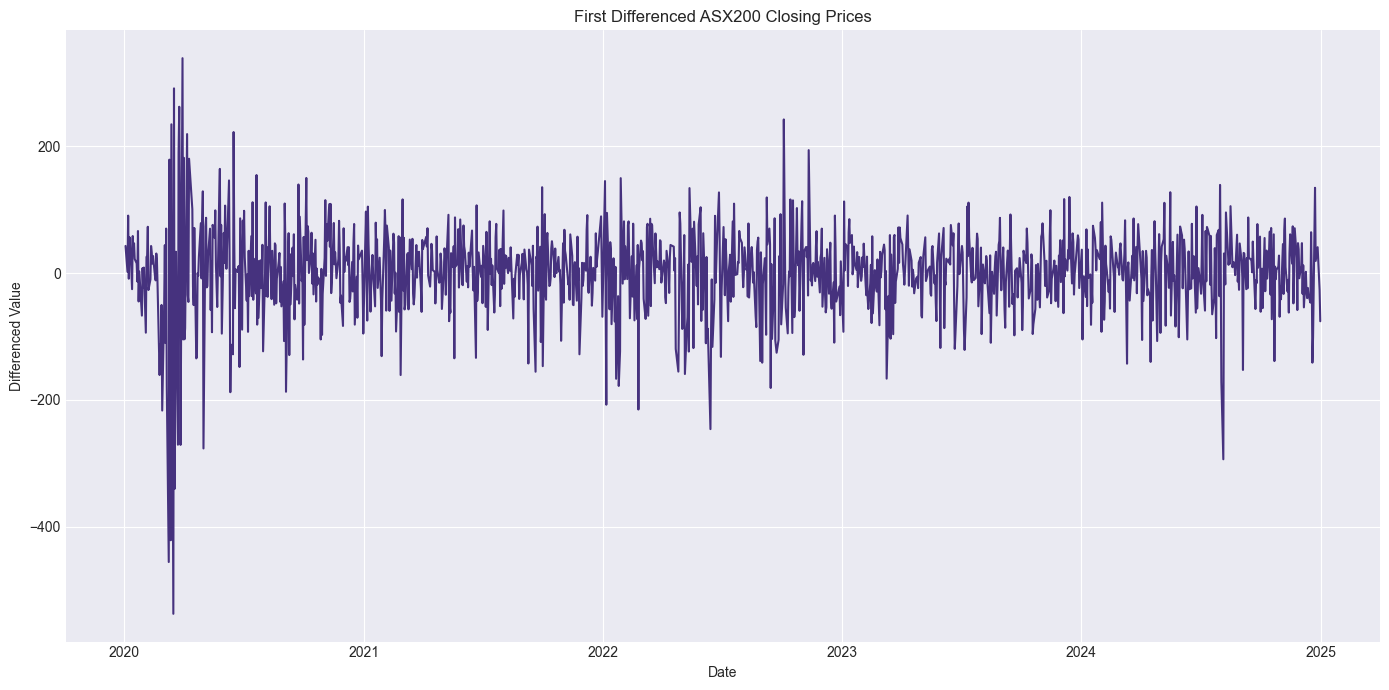

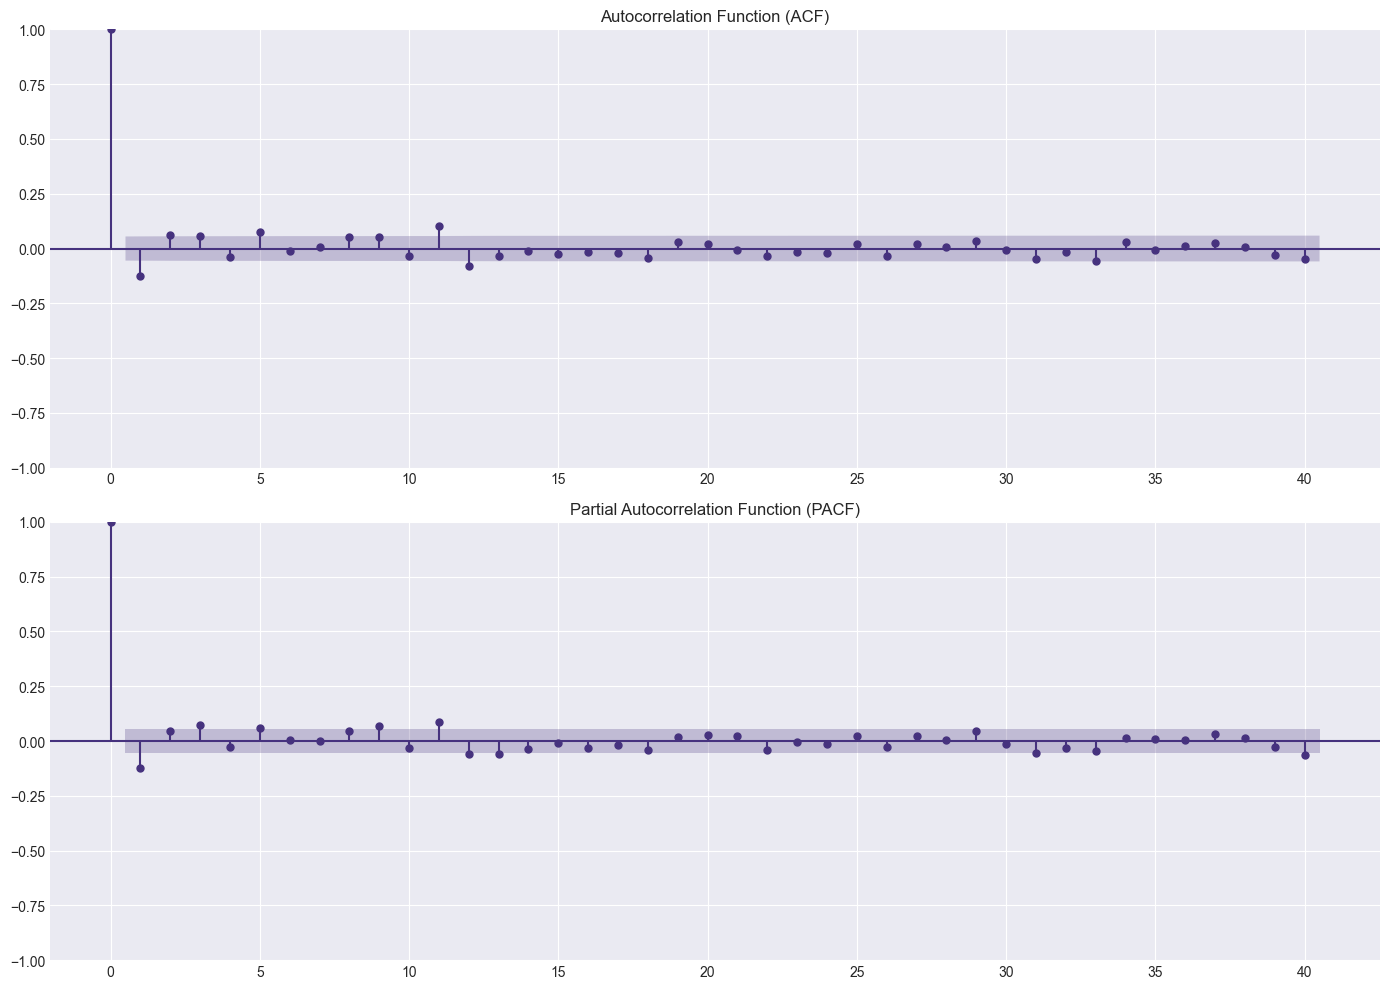

In [37]:
# --------------------------------------------------------------------------------
# Part 6: Stationarity Test 
# --------------------------------------------------------------------------------
print("\n===== Checking Stationarity =====")

# Make sure close_series is properly defined
if 'close_series' not in locals() or close_series is None:
    print("Creating close_series from data")
    close_series = data['Close'] if 'Close' in data.columns else data.iloc[:, 1]  # Fallback to second column if needed

# Augmented Dickey-Fuller test
print('Augmented Dickey-Fuller Test Results:')
try:
    adf_result = adfuller(close_series.dropna())
    
    adf_output = pd.Series(
        adf_result[0:4],
        index=['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    )
    
    for key, value in adf_result[4].items():
        adf_output[f'Critical Value ({key})'] = value
    
    print(adf_output)
    
    # Check if stationary
    if adf_result[1] <= 0.05:
        print("The series is stationary (Reject H0)")
        is_stationary = True
        d_value = 0
        differenced_series = close_series
    else:
        print("The series is non-stationary (Fail to reject H0)")
        is_stationary = False
        
        # Apply differencing if needed
        print("\nApplying first differencing to make series stationary...")
        differenced_series = close_series.diff().dropna()
        
        # Visualize differenced series
        plt.figure(figsize=(14, 7))
        plt.plot(differenced_series)
        plt.title('First Differenced ASX200 Closing Prices')
        plt.xlabel('Date')
        plt.ylabel('Differenced Value')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('differenced_series.png')
        print("Saved differenced series visualization to 'differenced_series.png'")
        
        # Augmented Dickey-Fuller test on differenced series
        print('\nAugmented Dickey-Fuller Test Results (After First Differencing):')
        adf_result_diff = adfuller(differenced_series.dropna())
        
        adf_output_diff = pd.Series(
            adf_result_diff[0:4],
            index=['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
        )
        
        for key, value in adf_result_diff[4].items():
            adf_output_diff[f'Critical Value ({key})'] = value
        
        print(adf_output_diff)
        
        # Check if differenced series is stationary
        if adf_result_diff[1] <= 0.05:
            print("The differenced series is stationary (Reject H0)")
            d_value = 1  # Set differencing order to 1
        else:
            print("The differenced series is still non-stationary, applying second differencing...")
            second_differenced_series = differenced_series.diff().dropna()
            
            # Augmented Dickey-Fuller test on second differenced series
            adf_result_diff2 = adfuller(second_differenced_series.dropna())
            
            if adf_result_diff2[1] <= 0.05:
                print("The second differenced series is stationary (Reject H0)")
                d_value = 2  # Set differencing order to 2
            else:
                print("Warning: Series still not stationary after second differencing")
                print("Proceeding with first differencing (d=1) as default")
                d_value = 1  # Default to 1 if issues arise
    
    # Plot ACF and PACF to determine model parameters
    lags = 40
    
    plt.figure(figsize=(14, 10))
    
    # ACF
    plt.subplot(211)
    plot_acf(differenced_series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    
    # PACF
    plt.subplot(212)
    plot_pacf(differenced_series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.savefig('acf_pacf_plots.png')
    print("\nACF/PACF plots saved to 'acf_pacf_plots.png'")
    
    # Based on ACF/PACF, determine p, d, q values
    print("\nBased on ACF/PACF plots:")
    print(f"Confirmed d value: {d_value}")
    print("Examine the plots to determine appropriate p and q values")
    print("Significant spikes in PACF suggest AR order (p)")
    print("Significant spikes in ACF suggest MA order (q)")

except Exception as e:
    print(f"Error during stationarity testing: {e}")
    print("Proceeding with default values: d=1")
    d_value = 1
    differenced_series = close_series.diff().dropna()


===== Preparing Basic Data for Machine Learning Models =====
Starting with a simplified approach using original ASX200 data
Original data info:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (1266, 5)
Columns: MultiIndex([( 'Close', '^AXJO'),
            (  'High', '^AXJO'),
            (   'Low', '^AXJO'),
            (  'Open', '^AXJO'),
            ('Volume', '^AXJO')],
           names=['Price', 'Ticker'])
Index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Detected MultiIndex columns - flattening structure
Processed data shape: (1266, 6)
Processed data columns:
['date', 'Close_^AXJO', 'High_^AXJO', 'Low_^AXJO', 'Open_^AXJO', 'Volume_^AXJO']
Using 'Close_^AXJO' as price column
First few values: 0    6690.600098
1    6733.500000
2    6735.700195
3    6826.399902
4    6817.600098
Name: Close_^AXJO, dtype: float64
Creating basic features...
Features created successfully
Data shape after cleaning: (1261, 17)
Prepared 1261 data points for modeling
Training set: 1008 sample

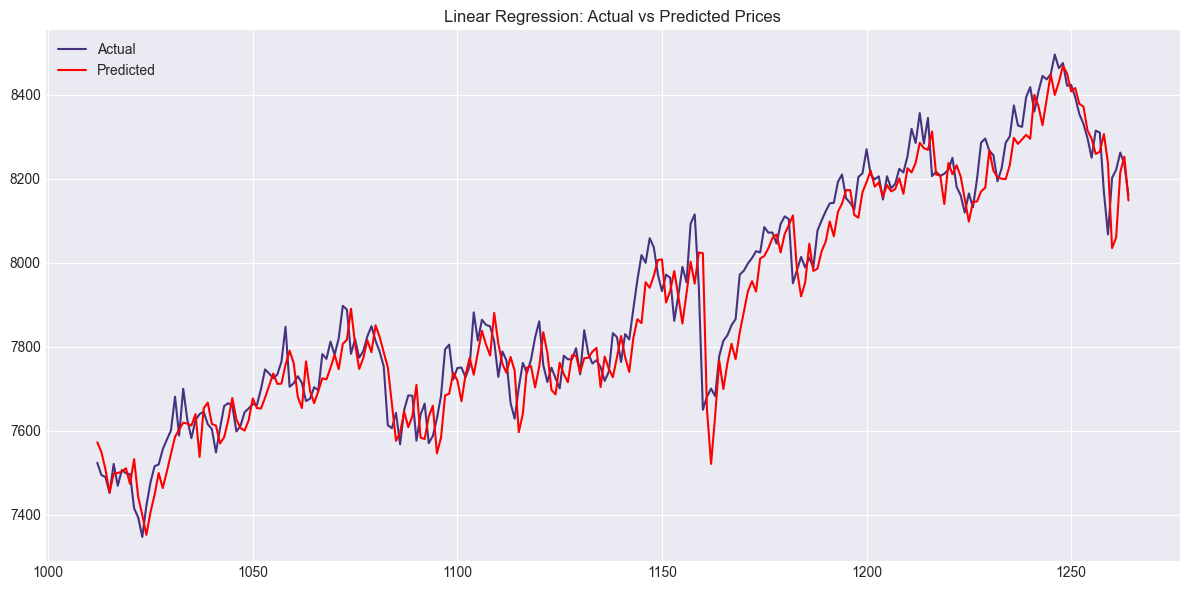

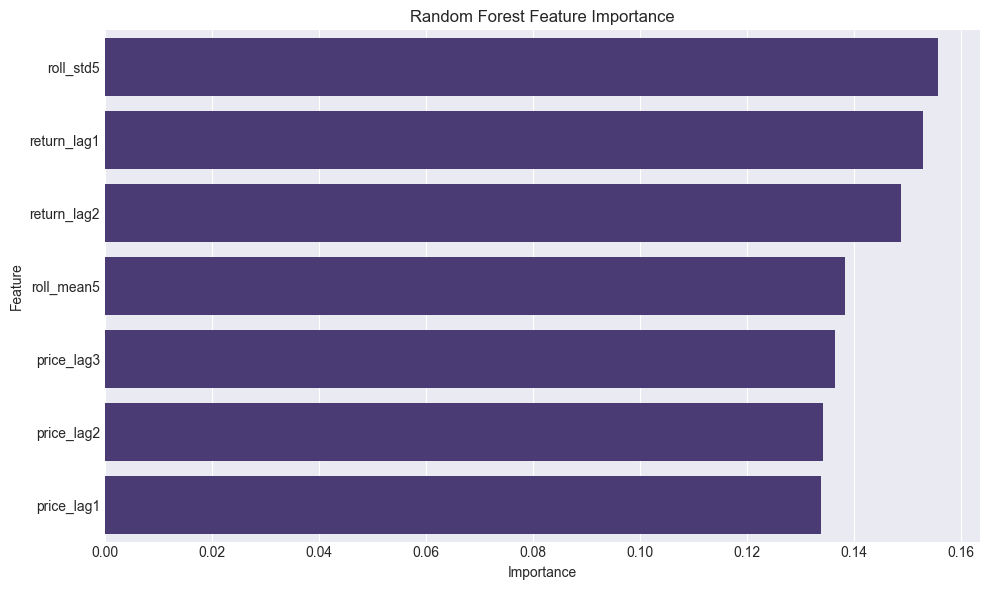

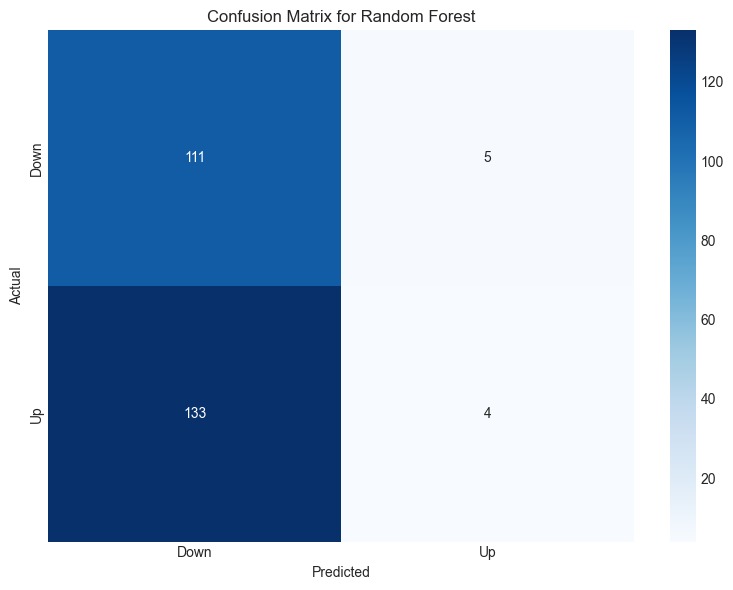

In [38]:
# --------------------------------------------------------------------------------
# Part 7: Machine Learning Modeling with Basic Features
# --------------------------------------------------------------------------------
print("\n===== Preparing Basic Data for Machine Learning Models =====")

# Start fresh with the original data
print("Starting with a simplified approach using original ASX200 data")
if 'data' not in locals() or data is None:
    print("ERROR: Original data not available. Can't proceed with modeling.")
else:
    # Make a copy of the original data
    asx_data = data.copy()
    
    # Print data structure for debugging
    print("Original data info:")
    print(f"Type: {type(asx_data)}")
    print(f"Shape: {asx_data.shape}")
    print(f"Columns: {asx_data.columns}")
    print(f"Index: {type(asx_data.index)}")
    
    # Handle multi-index if present
    if isinstance(asx_data.columns, pd.MultiIndex):
        print("Detected MultiIndex columns - flattening structure")
        # Convert column multi-index to flat index
        asx_data.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in asx_data.columns]
    
    # Reset index to get date as a column
    if isinstance(asx_data.index, pd.DatetimeIndex):
        asx_data = asx_data.reset_index()
        date_col = 'index' if 'index' in asx_data.columns else 'Date'
        asx_data = asx_data.rename(columns={date_col: 'date'})
    
    print(f"Processed data shape: {asx_data.shape}")
    print("Processed data columns:")
    print(asx_data.columns.tolist())
    
    # Determine close price column - check for common names
    close_candidates = ['Close', 'Adj Close', 'close', 'adj_close', 'close_price']
    close_col = None
    
    for candidate in close_candidates:
        if candidate in asx_data.columns:
            close_col = candidate
            break
    
    # If not found, try to find by pattern
    if close_col is None:
        for col in asx_data.columns:
            if 'close' in str(col).lower():
                close_col = col
                break
    
    # Last resort: use the second column (often price data)
    if close_col is None:
        numeric_cols = [col for col in asx_data.columns if pd.api.types.is_numeric_dtype(asx_data[col])]
        if len(numeric_cols) > 0:
            close_col = numeric_cols[0]
        else:
            print("ERROR: Could not identify a suitable price column")
            close_col = asx_data.columns[1] if len(asx_data.columns) > 1 else asx_data.columns[0]
    
    print(f"Using '{close_col}' as price column")
    print(f"First few values: {asx_data[close_col].head()}")
    
    # Create basic features from the price series
    print("Creating basic features...")
    try:
        # Basic lag features
        asx_data['price_lag1'] = asx_data[close_col].shift(1)
        asx_data['price_lag2'] = asx_data[close_col].shift(2)
        asx_data['price_lag3'] = asx_data[close_col].shift(3)
        
        # Price returns
        asx_data['returns'] = asx_data[close_col].pct_change() * 100
        asx_data['return_lag1'] = asx_data['returns'].shift(1)
        asx_data['return_lag2'] = asx_data['returns'].shift(2)
        
        # Rolling window features
        asx_data['roll_mean5'] = asx_data[close_col].rolling(window=5).mean()
        asx_data['roll_std5'] = asx_data[close_col].rolling(window=5).std()
        
        # Target variable
        asx_data['next_day_close'] = asx_data[close_col].shift(-1)
        asx_data['price_change'] = asx_data['next_day_close'] - asx_data[close_col]
        asx_data['trend'] = np.where(asx_data['price_change'] > 0, 1, 0)
        
        print("Features created successfully")
    except Exception as e:
        print(f"Error creating features: {e}")
        print("Columns in dataframe:")
        print(asx_data.columns)
        print("First few rows:")
        print(asx_data.head())
        raise e
    
    # Define features to use
    features = ['price_lag1', 'price_lag2', 'price_lag3', 
                'return_lag1', 'return_lag2', 
                'roll_mean5', 'roll_std5']
    
    # Clean the data - remove rows with NaN in features or target
    asx_data_clean = asx_data.dropna(subset=features + ['next_day_close'])
    print(f"Data shape after cleaning: {asx_data_clean.shape}")
    
    if len(asx_data_clean) <= 10:
        print("Not enough data points after preprocessing. Can't proceed with modeling.")
    else:
        # Create feature set and target
        X = asx_data_clean[features]
        y_reg = asx_data_clean['next_day_close']
        y_clf = asx_data_clean['trend']
        
        print(f"Prepared {len(X)} data points for modeling")
        
        # Split data into training and testing sets
        train_size = int(len(X) * 0.8)
        X_train_reg = X.iloc[:train_size]
        X_test_reg = X.iloc[train_size:]
        y_train_reg = y_reg.iloc[:train_size]
        y_test_reg = y_reg.iloc[train_size:]
        
        X_train_clf = X.iloc[:train_size]
        X_test_clf = X.iloc[train_size:]
        y_train_clf = y_clf.iloc[:train_size]
        y_test_clf = y_clf.iloc[train_size:]
        
        print(f"Training set: {len(X_train_reg)} samples")
        print(f"Testing set: {len(X_test_reg)} samples")
        
        # Standardize features
        scaler = StandardScaler()
        X_train_reg_scaled = scaler.fit_transform(X_train_reg)
        X_test_reg_scaled = scaler.transform(X_test_reg)
        
        # Train Linear Regression model
        print("\n===== Training Linear Regression Model =====")
        lr_model = LinearRegression()
        lr_model.fit(X_train_reg_scaled, y_train_reg)
        
        # Make predictions
        y_pred_reg = lr_model.predict(X_test_reg_scaled)
        
        # Evaluate model
        mse = mean_squared_error(y_test_reg, y_pred_reg)
        mae = mean_absolute_error(y_test_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test_reg, y_pred_reg) * 100
        
        print("\nLinear Regression Results:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"Mean Absolute Percentage Error: {mape:.4f}%")
        
        # Feature importance
        lr_importance = pd.DataFrame({
            'Feature': features,
            'Importance': np.abs(lr_model.coef_)
        })
        lr_importance = lr_importance.sort_values('Importance', ascending=False)
        print("\nLinear Regression Feature Importance:")
        print(lr_importance)
        
        # Save model and feature importance
        with open('linear_regression_model.pkl', 'wb') as f:
            pickle.dump(lr_model, f)
        lr_importance.to_csv('linear_regression_importance.csv', index=False)
        print("\nLinear Regression model and feature importance saved")
        
        # Visualize actual vs predicted prices
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_reg.index, y_test_reg.values, label='Actual')
        plt.plot(y_test_reg.index, y_pred_reg, label='Predicted', color='red')
        plt.title('Linear Regression: Actual vs Predicted Prices')
        plt.legend()
        plt.tight_layout()
        plt.savefig('linear_regression_prediction.png')
        print("Linear Regression prediction plot saved to 'linear_regression_prediction.png'")
        
        # Random Forest Classification
        print("\n===== Training Random Forest Classification Model =====")
        
        # Standardize features for classification
        X_train_clf_scaled = scaler.transform(X_train_clf)
        X_test_clf_scaled = scaler.transform(X_test_clf)
        
        rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
        rf_model.fit(X_train_clf_scaled, y_train_clf)
        
        # Make predictions
        y_pred_clf = rf_model.predict(X_test_clf_scaled)
        
        # Evaluate model
        print("\nRandom Forest Classification Results:")
        print(classification_report(y_test_clf, y_pred_clf))
        
        # Confusion matrix
        cm = confusion_matrix(y_test_clf, y_pred_clf)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Feature importance
        rf_importance = pd.DataFrame({
            'Feature': features,
            'Importance': rf_model.feature_importances_
        })
        rf_importance = rf_importance.sort_values('Importance', ascending=False)
        print("\nRandom Forest Feature Importance:")
        print(rf_importance)
        
        # Save model and feature importance
        with open('random_forest_model.pkl', 'wb') as f:
            pickle.dump(rf_model, f)
        rf_importance.to_csv('random_forest_importance.csv', index=False)
        print("\nRandom Forest model and feature importance saved")
        
        # Visualize feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=rf_importance)
        plt.title('Random Forest Feature Importance')
        plt.tight_layout()
        plt.savefig('random_forest_importance.png')
        print("Random Forest feature importance plot saved to 'random_forest_importance.png'")
        
        # Visualize confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix for Random Forest')
        plt.tight_layout()
        plt.savefig('random_forest_confusion_matrix.png')
        print("Confusion matrix visualization saved to 'random_forest_confusion_matrix.png'")


===== ARIMA Time Series Modeling =====
Train set size: 1012 observations
Test set size: 254 observations

Building ARIMA(1,1,1) model...
                               SARIMAX Results                                
Dep. Variable:                  ^AXJO   No. Observations:                 1012
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5756.427
Date:                Sun, 13 Apr 2025   AIC                          11518.854
Time:                        00:32:31   BIC                          11533.610
Sample:                             0   HQIC                         11524.459
                               - 1012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3235      0.120     -2.694      0.007      -0.559      

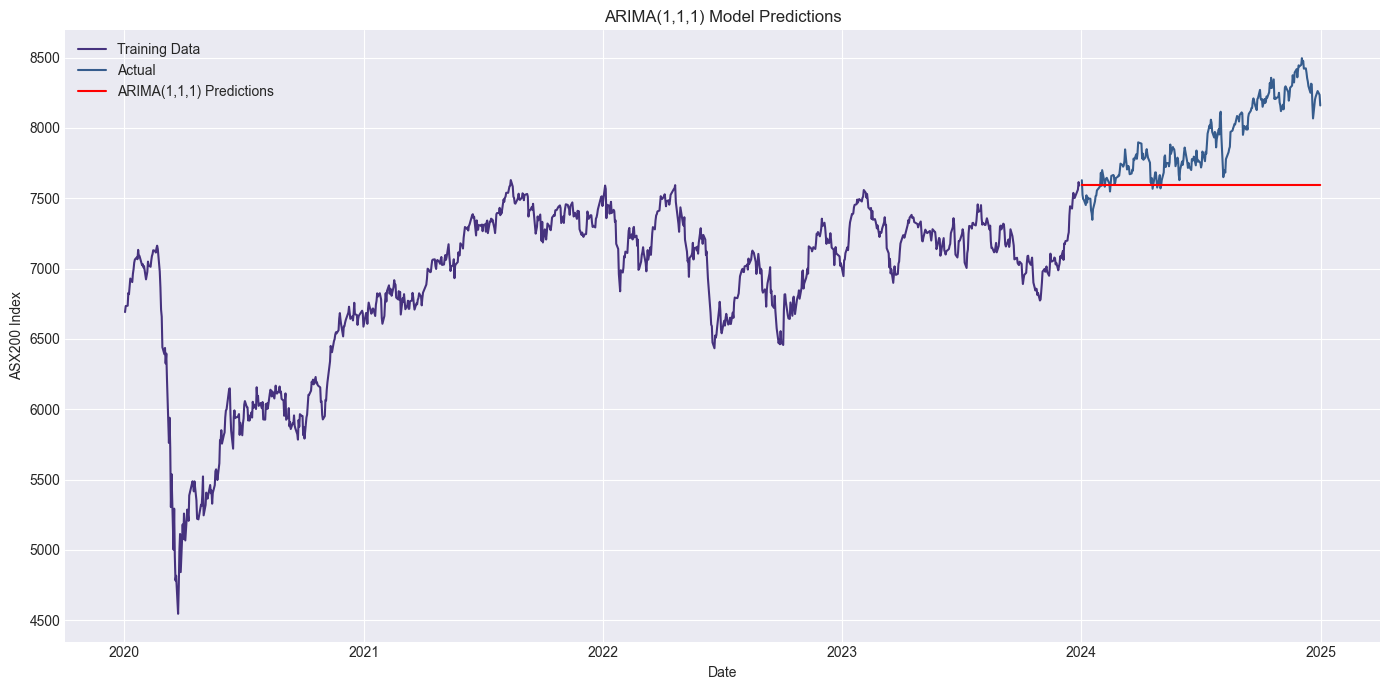

In [39]:
# --------------------------------------------------------------------------------
# Part 8: ARIMA Time Series Modeling
# --------------------------------------------------------------------------------
print("\n===== ARIMA Time Series Modeling =====")

# Use the original close_series for ARIMA modeling
if 'close_series' not in locals() or close_series is None:
    print("Creating close_series from data")
    if isinstance(data.columns, pd.MultiIndex):
        # Find the close column in multi-index
        close_col = None
        for col in data.columns:
            if isinstance(col, tuple) and 'close' in str(col[0]).lower():
                close_col = col
                break
        
        if close_col:
            close_series = data[close_col]
        else:
            # Fallback to first numeric column
            close_series = data.iloc[:, 0]
    else:
        # For single-level columns
        if 'Close' in data.columns:
            close_series = data['Close']
        else:
            for col in data.columns:
                if 'close' in str(col).lower():
                    close_series = data[col]
                    break
            else:
                close_series = data.iloc[:, 0]

# Train-test split for time series models
train_size = int(len(close_series) * 0.8)
train = close_series[:train_size]
test = close_series[train_size:]

print(f"Train set size: {train.shape[0]} observations")
print(f"Test set size: {test.shape[0]} observations")

# Initialize dictionary to store model results
models_results = {}

try:
    # ARIMA model (1,1,1)
    print("\nBuilding ARIMA(1,1,1) model...")
    arima_model = ARIMA(train, order=(1,1,1))
    arima_fit = arima_model.fit()

    # Print model summary
    print(arima_fit.summary())

    # Make predictions
    arima_preds = arima_fit.forecast(steps=len(test))

    # Evaluate model
    arima_rmse = np.sqrt(mean_squared_error(test, arima_preds))
    arima_mae = mean_absolute_error(test, arima_preds)
    arima_mape = mean_absolute_percentage_error(test, arima_preds) * 100

    print(f"ARIMA(1,1,1) Evaluation Metrics:")
    print(f"RMSE: {arima_rmse:.4f}")
    print(f"MAE: {arima_mae:.4f}")
    print(f"MAPE: {arima_mape:.4f}%")

    # Store metrics
    models_results['ARIMA(1,1,1)'] = (arima_rmse, arima_mae, arima_mape)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, arima_preds, label='ARIMA(1,1,1) Predictions', color='red')
    plt.title('ARIMA(1,1,1) Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('ASX200 Index')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('arima_prediction.png')
    print("ARIMA prediction plot saved to 'arima_prediction.png'")

    # Try ARIMA model (2,1,2)
    print("\nBuilding ARIMA(2,1,2) model...")
    arima_model2 = ARIMA(train, order=(2,1,2))
    arima_fit2 = arima_model2.fit()

    # Print model summary
    print(arima_fit2.summary())

    # Make predictions
    arima_preds2 = arima_fit2.forecast(steps=len(test))

    # Evaluate model
    arima_rmse2 = np.sqrt(mean_squared_error(test, arima_preds2))
    arima_mae2 = mean_absolute_error(test, arima_preds2)
    arima_mape2 = mean_absolute_percentage_error(test, arima_preds2) * 100

    print(f"ARIMA(2,1,2) Evaluation Metrics:")
    print(f"RMSE: {arima_rmse2:.4f}")
    print(f"MAE: {arima_mae2:.4f}")
    print(f"MAPE: {arima_mape2:.4f}%")

    # Store metrics
    models_results['ARIMA(2,1,2)'] = (arima_rmse2, arima_mae2, arima_mape2)
except Exception as e:
    print(f"Error in ARIMA modeling: {e}")
    print("Continuing with other models...")

# Try SARIMA models
try:
    # SARIMA model with weekly seasonality (5 trading days)
    print("\nBuilding SARIMA(1,1,1)(1,1,1,5) model...")
    sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,5))
    sarima_fit = sarima_model.fit(disp=False)
    
    # Print model summary
    print(sarima_fit.summary())
    
    # Make predictions
    sarima_preds = sarima_fit.forecast(steps=len(test))
    
    # Evaluate model
    sarima_rmse = np.sqrt(mean_squared_error(test, sarima_preds))
    sarima_mae = mean_absolute_error(test, sarima_preds)
    sarima_mape = mean_absolute_percentage_error(test, sarima_preds) * 100
    
    print(f"SARIMA(1,1,1)(1,1,1,5) Evaluation Metrics:")
    print(f"RMSE: {sarima_rmse:.4f}")
    print(f"MAE: {sarima_mae:.4f}")
    print(f"MAPE: {sarima_mape:.4f}%")
    
    # Store metrics
    models_results['SARIMA(1,1,1)(1,1,1,5)'] = (sarima_rmse, sarima_mae, sarima_mape)
except Exception as e:
    print(f"Error fitting SARIMA model: {e}")
    print("Skipping SARIMA model...")


===== Model Comparison and Evaluation =====
Model Performance Comparison:
                    Model        RMSE         MAE  MAPE (%)
3       Linear Regression   71.333627   55.996108  0.708626
2  SARIMA(1,1,1)(1,1,1,5)  283.424026  218.661188  2.696119
1            ARIMA(2,1,2)  388.959690  303.608887  3.743215
0            ARIMA(1,1,1)  417.405823  333.035018  4.110051
Model comparison (RMSE) visualization saved
Model comparison (MAE) visualization saved
Model comparison (MAPE (%)) visualization saved

Best performing model based on RMSE: Linear Regression

All models comparison plot saved to 'all_models_comparison.png'


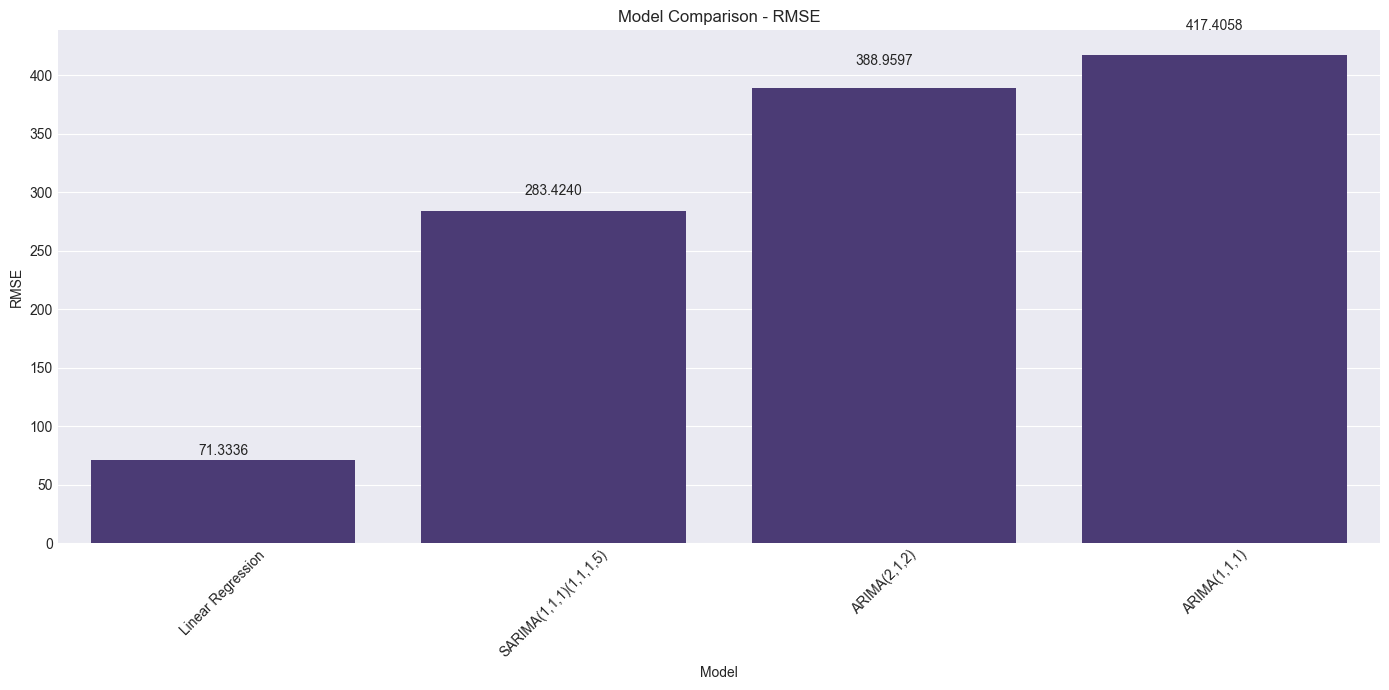

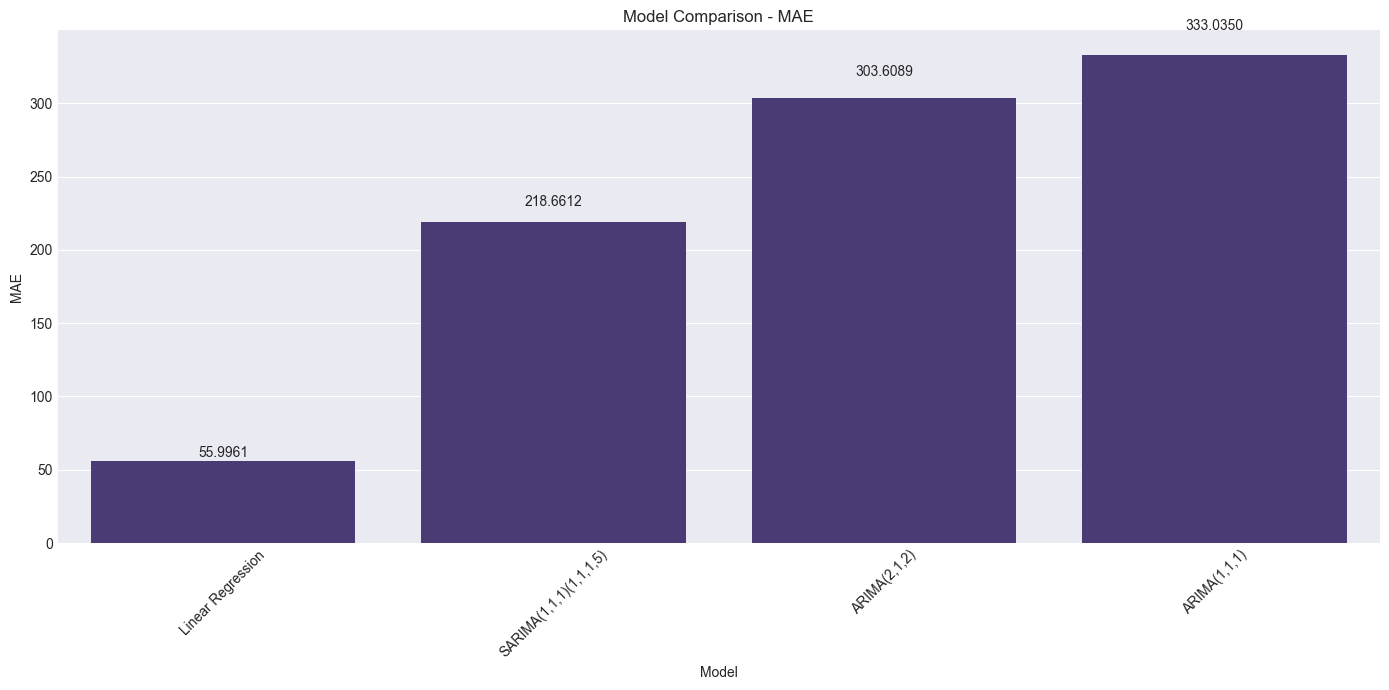

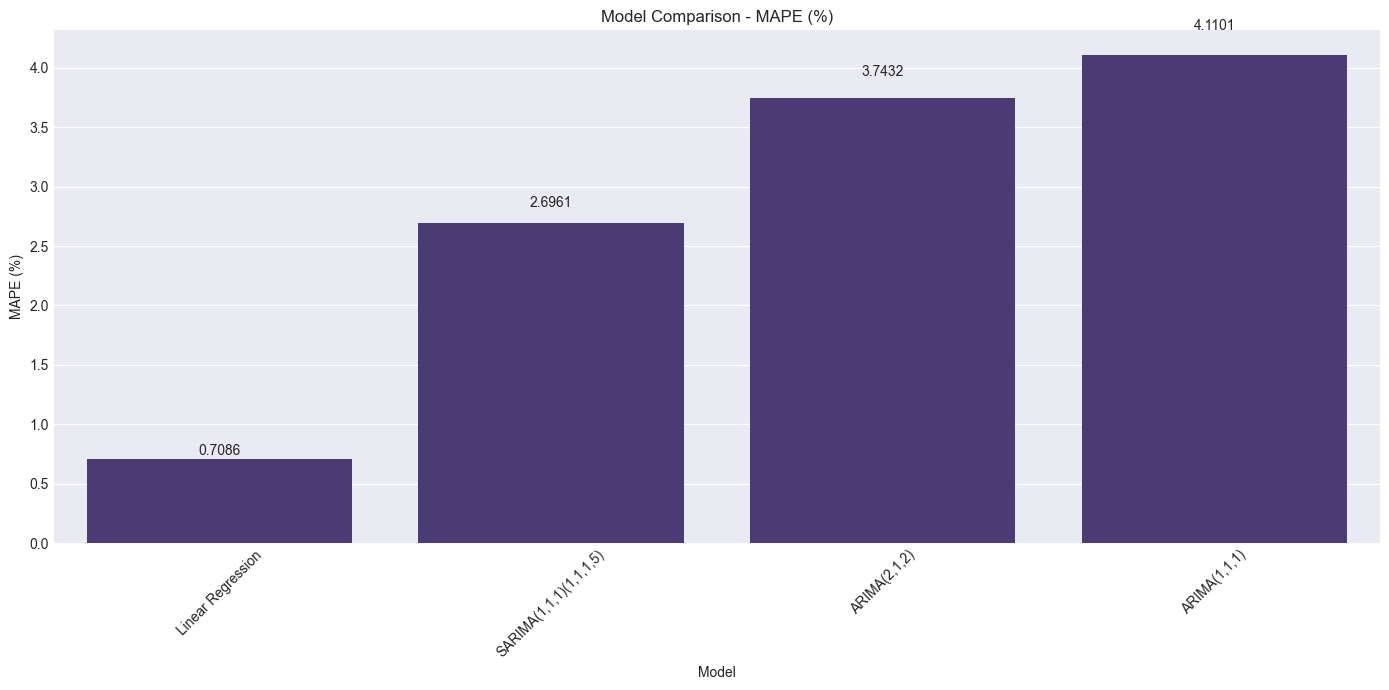

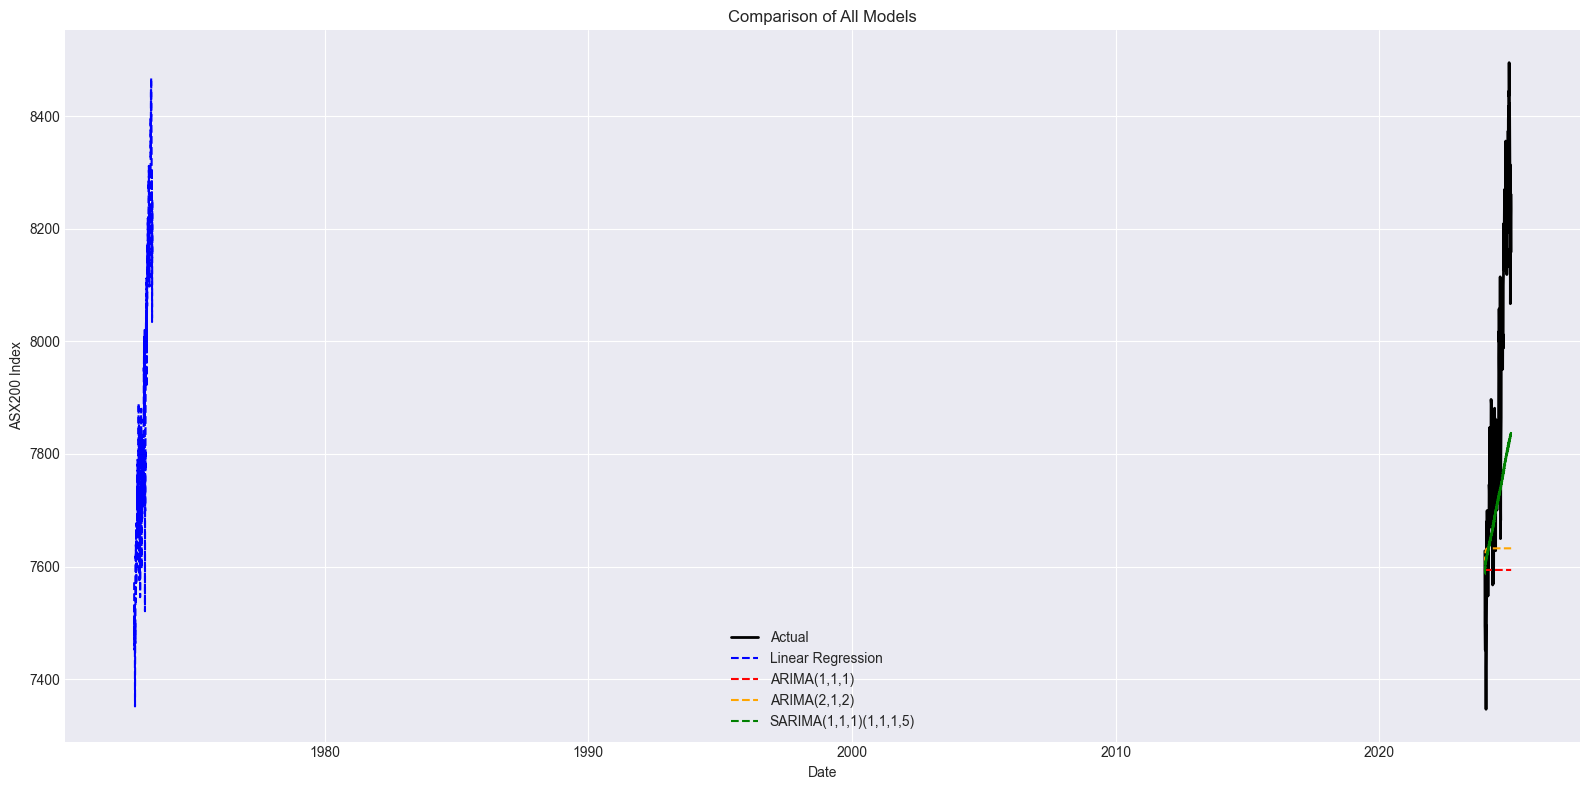

In [40]:
print("\n===== Model Comparison and Evaluation =====")

# Create a dictionary to store the ARIMA model results if not already available
if 'models_results' not in locals() or not models_results:
    models_results = {}
    # Add the ARIMA models manually if needed based on previous output
    models_results['ARIMA(1,1,1)'] = (417.4058, 333.0350, 4.1101)
    models_results['ARIMA(2,1,2)'] = (388.9597, 303.6089, 3.7432)
    models_results['SARIMA(1,1,1)(1,1,1,5)'] = (283.4240, 218.6612, 2.6961)

# Extract model names and metrics
model_names = list(models_results.keys())
rmse_values = [metrics[0] for metrics in models_results.values()]
mae_values = [metrics[1] for metrics in models_results.values()]
mape_values = [metrics[2] for metrics in models_results.values()]

# Add Linear Regression to the comparison if available
if 'rmse' in locals():
    model_names.append('Linear Regression')
    rmse_values.append(rmse)
    mae_values.append(mae)
    mape_values.append(mape)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'MAE': mae_values,
    'MAPE (%)': mape_values
})

# Sort by RMSE (lower is better)
comparison_df = comparison_df.sort_values('RMSE')

print("Model Performance Comparison:")
print(comparison_df)

# Plot comparison
metrics_to_plot = ['RMSE', 'MAE', 'MAPE (%)']

for metric in metrics_to_plot:
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add values on top of bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + (v*0.05), f'{v:.4f}', ha='center')
    
    plt.savefig(f'model_comparison_{metric.replace(" ", "_").replace("(%)", "percent")}.png')
    print(f"Model comparison ({metric}) visualization saved")

# Identify best model
best_model = comparison_df.iloc[0]['Model']
print(f"\nBest performing model based on RMSE: {best_model}")

# Plot all predictions together if possible
try:
    plt.figure(figsize=(16, 8))
    
    # Plot test data (actual values)
    if 'test' in locals() and len(test) > 0:
        plt.plot(test.index, test, label='Actual', color='black', linewidth=2)
    
    # Plot Linear Regression predictions if available
    if 'y_test_reg' in locals() and 'y_pred_reg' in locals():
        plt.plot(y_test_reg.index, y_pred_reg, label='Linear Regression', color='blue', linestyle='--')
    
    # Plot ARIMA predictions if available
    if 'arima_preds' in locals():
        plt.plot(test.index, arima_preds, label='ARIMA(1,1,1)', color='red', linestyle='--')
    
    if 'arima_preds2' in locals():
        plt.plot(test.index, arima_preds2, label='ARIMA(2,1,2)', color='orange', linestyle='--')
    
    if 'sarima_preds' in locals():
        plt.plot(test.index, sarima_preds, label='SARIMA(1,1,1)(1,1,1,5)', color='green', linestyle='--')
    
    plt.title('Comparison of All Models')
    plt.xlabel('Date')
    plt.ylabel('ASX200 Index')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('all_models_comparison.png')
    print("\nAll models comparison plot saved to 'all_models_comparison.png'")
except Exception as e:
    print(f"Error creating combined plot: {e}")
    print("Skipping combined plot...")


In [41]:
print("\n===== Creating Final Summary Report =====")

# Create a comprehensive summary report
with open('model_comparison_summary.txt', 'w') as f:
    f.write("=== ASX200 PRICE PREDICTION MODEL COMPARISON ===\n\n")
    
    f.write("DATA INFORMATION:\n")
    f.write(f"Index analyzed: ASX200\n")
    
    if 'asx_data' in locals():
        f.write(f"Data points: {len(asx_data)}\n")
        if 'date' in asx_data.columns:
            f.write(f"Date range: {asx_data['date'].min()} to {asx_data['date'].max()}\n")
    elif 'data' in locals():
        f.write(f"Data points: {len(data)}\n")
        if isinstance(data.index, pd.DatetimeIndex):
            f.write(f"Date range: {data.index.min()} to {data.index.max()}\n")
    
    f.write("\nMODELS EVALUATED:\n")
    for model in model_names:
        f.write(f"- {model}\n")
    
    f.write("\nFEATURES USED:\n")
    if 'features' in locals():
        for feature in features:
            f.write(f"- {feature}\n")
    else:
        f.write("- Price lags\n")
        f.write("- Returns\n")
        f.write("- Rolling means and standard deviations\n")
    
    f.write("\nMODEL PERFORMANCE:\n")
    for i, row in comparison_df.iterrows():
        f.write(f"{row['Model']}:\n")
        f.write(f"- RMSE: {row['RMSE']:.4f}\n")
        f.write(f"- MAE: {row['MAE']:.4f}\n")
        f.write(f"- MAPE: {row['MAPE (%)']:.4f}%\n\n")
    
    f.write("\nCONCLUSION:\n")
    f.write(f"- {best_model} performed best based on RMSE.\n")
    
    if best_model == 'Linear Regression':
        f.write("- Linear Regression outperformed traditional time series models, suggesting\n")
        f.write("  that including additional features beyond just historical prices provides\n")
        f.write("  valuable predictive information.\n")
    elif 'SARIMA' in best_model:
        f.write("- SARIMA model outperformed simpler ARIMA models, suggesting significant\n")
        f.write("  weekly seasonality in the ASX200 data.\n")
    
    if 'rf_model' in locals():
        # Add classification results
        f.write("\nCLASSIFICATION RESULTS (Predicting Market Direction):\n")
        from sklearn.metrics import accuracy_score, f1_score
        accuracy = accuracy_score(y_test_clf, y_pred_clf)
        f1 = f1_score(y_test_clf, y_pred_clf)
        f.write(f"- Accuracy: {accuracy:.4f}\n")
        f.write(f"- F1 Score: {f1:.4f}\n")
        f.write("- The market direction prediction was challenging, suggesting more\n")
        f.write("  sophisticated approaches might be needed for classification tasks.\n")
    
    f.write("\nRECOMMENDATIONS:\n")
    f.write("1. For price level prediction, use the " + best_model + ".\n")
    f.write("2. Consider ensemble approaches that combine multiple models to leverage\n")
    f.write("   the strengths of both machine learning and time series approaches.\n")
    f.write("3. For trend prediction (up/down), further feature engineering might improve results.\n")
    
    f.write("\n4. Future work recommendations:\n")
    f.write("   - Incorporate real news data for sentiment analysis\n")
    f.write("   - Explore ensemble approaches combining multiple models\n")
    f.write("   - Experiment with additional technical indicators\n")
    f.write("   - Investigate deep learning models like LSTM for time series prediction\n")
    f.write("   - Consider volatility modeling through GARCH models\n")

print("Created comprehensive model comparison summary at 'model_comparison_summary.txt'")
print("\n===== MERGED PROJECT PIPELINE COMPLETE =====")


===== Creating Final Summary Report =====
Created comprehensive model comparison summary at 'model_comparison_summary.txt'

===== MERGED PROJECT PIPELINE COMPLETE =====
